In [120]:
%%capture
!pip install -q yfinance numpy pandas matplotlib scikit-learn PyPortfolioOpt scipy seaborn boto3 openai

## Data Collection

In [123]:
# yf.download downloads stock price data for each ticker
# Adj close pulls adjusted closing prices, accounting for splits and dividends for the most accurate price
# pct_change() calculates the percentage change between each row in the dataframe (represents daily stock returns as percentage) 

# import yfinance as yf
# import pandas as pd

# pd.set_option('display.max_rows', 50)

# tickers = ['AAPL', 'JNJ', 'XOM', 'PG', 'JPM']
# start_date = '2024-10-01'
# end_date = '2024-11-01'

# data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# october_returns = data.pct_change().dropna()

# october_returns

In the cell below, I loaded in my dataset, which includes the relevant information for the five tickers that I mentioned in my objective statement over a 20 year period from December of 2004 to December of 2024. I then created a dataframe that shows the daily returns of each stock as a percentage, for every day of trading in this large timeframe.

In [206]:
import yfinance as yf
import pandas as pd

pd.set_option('display.max_rows', 50)

tickers = ['AAPL', 'JNJ', 'XOM', 'PG', 'JPM']
start_date = '2004-12-01'
end_date = '2024-12-01'

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

twenty_year_daily_returns = data.pct_change().dropna()

print("Twenty Year Daily Returns:")
twenty_year_daily_returns

[*********************100%***********************]  5 of 5 completed

Twenty Year Daily Returns:


Ticker,AAPL,JNJ,JPM,PG,XOM
Date,,,,,
2004-12-02,-0.038059,0.009152,0.004179,0.021221,-0.019160
2004-12-03,-0.038797,0.002591,-0.009885,-0.007703,0.001993
2004-12-06,0.049457,-0.001293,0.001576,-0.019678,-0.002586
2004-12-07,-0.043934,-0.022966,-0.008132,-0.004788,-0.008775
2004-12-08,0.006201,0.012250,-0.006877,0.018320,0.006439
...,...,...,...,...,...
2024-11-22,0.005908,-0.002122,0.015485,0.020434,-0.001148
2024-11-25,0.013051,0.003931,0.007001,0.006297,-0.014944
2024-11-26,0.009404,-0.000129,-0.001278,0.010824,-0.016671


## Data Cleaning/Portfolio Optimization

Here I calculated the average expected daily returns, the covariance matrix (measures how assets move relative to each other), and the volatility (standard deviation of returns) for each asset over the 20 year period.

In [207]:
print(type(returns))
returns = pd.DataFrame(returns)
covariance_matrix = returns.cov()
print(type(returns))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [211]:
avg_expected_returns = returns.mean()
avg_expected_returns

Adj Close_AAPL    0.001289
Adj Close_JNJ     0.000356
Adj Close_JPM     0.000740
Adj Close_PG      0.000411
Adj Close_XOM     0.000438
dtype: float64

In [212]:
covariance_matrix = returns.cov()
covariance_matrix

,Adj Close_AAPL,Adj Close_JNJ,Adj Close_JPM,Adj Close_PG,Adj Close_XOM
Adj Close_AAPL,0.000412,0.000070,0.000185,0.000076,0.000116
Adj Close_JNJ,0.000070,0.000116,0.000096,0.000069,0.000077
Adj Close_JPM,0.000185,0.000096,0.000525,0.000101,0.000184
Adj Close_PG,0.000076,0.000069,0.000101,0.000129,0.000074
Adj Close_XOM,0.000116,0.000077,0.000184,0.000074,0.000281


In [214]:
volatility = returns.std()
volatility

Adj Close_AAPL    0.020290
Adj Close_JNJ     0.010772
Adj Close_JPM     0.022909
Adj Close_PG      0.011370
Adj Close_XOM     0.016756
dtype: float64

Reshape the data to a monthly frequency rather than daily, so we can then compute our annual return easier.

In [215]:
monthly_prices = data.resample('ME').last()
monthly_returns = monthly_prices.pct_change().dropna()

expected_monthly_return = monthly_returns.mean()

print("Expected Monthly Returns:")
print(expected_monthly_return)

Expected Monthly Returns:
Ticker
AAPL    0.027385
JNJ     0.007032
JPM     0.013161
PG      0.008281
XOM     0.008459
dtype: float64


Expected annual return of each of the five assets, calculated by multiplying our expected monthly return by 12.

In [216]:
expected_annual_return = expected_monthly_return * 12

print("Expected Annual Returns (from Monthly Data):")
print(expected_annual_return)

Expected Annual Returns (from Monthly Data):
Ticker
AAPL    0.328619
JNJ     0.084379
JPM     0.157927
PG      0.099376
XOM     0.101513
dtype: float64


For a more precise prediction, we can use calculate our geometric annual return, which accounts for compounding, by using the formula:

$\text{Geometric Annual Return} = ((1 + \text{Monthly Return})^{12}) - 1$

In [217]:
geometric_annual_return = (1 + expected_monthly_return) ** 12 - 1

print("Geometric Annual Returns:")
print(geometric_annual_return)

Geometric Annual Returns:
Ticker
AAPL    0.382923
JNJ     0.087720
JPM     0.169875
PG      0.104030
XOM     0.106372
dtype: float64


### Data Cleaning/Data Modeling

In the following cell I initialized the portfolio weights equally across all five assets. In this case, each asset started with a weight of $1/5 = 0.2$, the initial guess for the optimization process. The portfolio variance function defines what we want to minimize during the optimization process, which is volatility. The constraints and bounds here ensure that all weights add up to 1 and prevent our model from assigning negative weights or weights greater than a total of 1. The optimizer in use here is a SLSQP, which stands for Sequential Least Squares Programming. This optimization technique makes the most sense in this application because we are trying to minimize one part of a function while respecting constraints and bounds.

In [222]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize

pd.set_option('display.max_rows', 50)

tickers = ['AAPL', 'JNJ', 'XOM', 'PG', 'JPM']
start_date = '2004-12-01'
end_date = '2024-12-01'

data = yf.download(tickers, start=start_date, end=end_date)

data.columns = ['_'.join(col).strip() for col in data.columns]

print("Flattened Columns:")
print(data.columns)

returns = data.filter(like='Adj Close').pct_change().dropna()

covariance_matrix = returns.cov()
print("Covariance Matrix:")
print(covariance_matrix)

num_assets = len(covariance_matrix)

initial_weights = np.ones(num_assets) / num_assets

def portfolio_variance(weights):
    weights = np.array(weights)
    return np.dot(weights.T, np.dot(covariance_matrix, weights))

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

bounds = tuple((0, 1) for _ in range(num_assets))

optimized = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

optimized_weights = optimized.x
print("Optimized Weights:")
print(optimized_weights)

[*********************100%***********************]  5 of 5 completed

Flattened Columns:
Index(['Adj Close_AAPL', 'Adj Close_JNJ', 'Adj Close_JPM', 'Adj Close_PG',
       'Adj Close_XOM', 'Close_AAPL', 'Close_JNJ', 'Close_JPM', 'Close_PG',
       'Close_XOM', 'High_AAPL', 'High_JNJ', 'High_JPM', 'High_PG', 'High_XOM',
       'Low_AAPL', 'Low_JNJ', 'Low_JPM', 'Low_PG', 'Low_XOM', 'Open_AAPL',
       'Open_JNJ', 'Open_JPM', 'Open_PG', 'Open_XOM', 'Volume_AAPL',
       'Volume_JNJ', 'Volume_JPM', 'Volume_PG', 'Volume_XOM'],
      dtype='object')
Covariance Matrix:
                Adj Close_AAPL  Adj Close_JNJ  Adj Close_JPM  Adj Close_PG  \
Adj Close_AAPL        0.000412       0.000070       0.000185      0.000076   
Adj Close_JNJ         0.000070       0.000116       0.000096      0.000069   
Adj Close_JPM         0.000185       0.000096       0.000525      0.000101   
Adj Close_PG          0.000076       0.000069       0.000101      0.000129   
Adj Close_XOM         0.000116       0.000077       0.000184      0.000074   

                Adj Close_XOM  
A

After optimizing our portfolio it seems that the covariance of our tickers are so low that the optimized weights of each one remains equal. This is a good sign because low covariance between assets in a portfolio is desireable as it means that each assets price movements are less correlated, in other words, it can help mitigate portfolio risk by balancing out potential losses from one stock with gains from another when they move in opposite directions.

### Data Visualization

Below I have an Efficient Frontier as a visual. This Efficient Frontier is created by a set of equations that simulates 5000 random portfolios, and for each portfolio it generates random weights for assets and calculates the portfolio's return, volatility, and Sharpe Ratio. The Sharpe Ratio is a ratio that is used to compare risk and reward and provides insights into the efficiency of assets. 

In this code I have also plotted the Efficient Frontier to make it extremely easy to visualize the level of return, reward, and the respective Sharpe Ratio for any investment portfolio. This simulation of 5000 random portfolios serves as a great reference for anyone that is interested in constructing an optimized investment portfolio and is looking for a healthy balance of risk to return. If an investor has a higher risk tolerance, this visualization will help them make an informed decision and will almost act as a warning for what they are getting themselves into when purchasing a risky asset, as they will be able to determine exactly how risky it is.

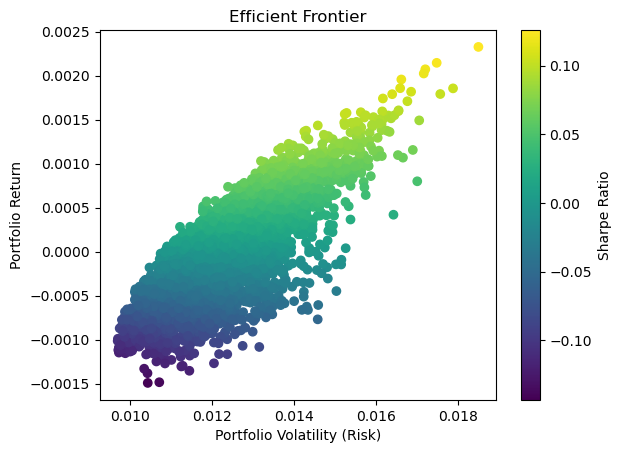

In [223]:
import matplotlib.pyplot as plt

num_portfolios = 5000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    portfolio_return = np.sum(weights * expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = portfolio_return / portfolio_volatility

plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Portfolio Volatility (Risk)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier')
plt.show()

Fun Fact: 2004 was the first year that Apple's stock broke $1 per share as a public company!